In [4]:
import sklearn
import os
from sklearn.datasets import make_circles
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_HIP_DSA'] = '1'

In [5]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)


In [6]:
len(X), len(y)

(1000, 1000)

In [7]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of y:\n {y[:5]}')

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [8]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


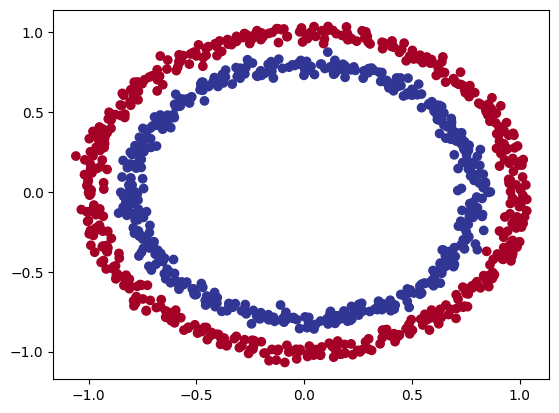

In [9]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c = y, cmap=plt.cm.RdYlBu)

In [10]:
# check input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [12]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [13]:
# Turn data into tensors and create train and test splits
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [14]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [16]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [17]:
#building a model
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [18]:
class CircleModelV0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Create nn.Linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    

In [19]:
device

'cpu'

In [20]:
#replicating the model using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_0
next(model_0.parameters())

Parameter containing:
tensor([[ 0.0323, -0.6734],
        [ 0.2710, -0.6267],
        [-0.0145,  0.0629],
        [-0.6039, -0.0669],
        [-0.5167, -0.3450]], requires_grad=True)

In [21]:
#Make predictions

untrained_preds = model_0(X_test)
print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFirst predictions:\n{untrained_preds[:10]}')
print(f'\nFirst 10 labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First predictions:
tensor([[-0.2178],
        [ 0.0311],
        [-0.5874],
        [-0.1143],
        [-0.1383],
        [ 0.0102],
        [ 0.3552],
        [ 0.3514],
        [-0.6058],
        [ 0.0528]], grad_fn=<SliceBackward0>)

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [22]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [23]:
# Setup loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss() #signoid activation func

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [24]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [25]:
# Train the model
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits

tensor([[-0.2178],
        [ 0.0311],
        [-0.5874],
        [-0.1143],
        [-0.1383]])

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [27]:
# use the sigmoid activation func on our model to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4458],
        [0.5078],
        [0.3572],
        [0.4715],
        [0.4655]])

In [28]:
torch.round(y_pred_probs)

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.]])

In [29]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test))[:5])

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 1., 0., 0., 0.])

In [30]:
#training loop and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#epochs
epochs = 1000

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(torch.sigmoid(y_logits), y_train) #nn.BCELoss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) #nn.BCEWithLogitsLoss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.70916 | Acc: 48.62500% | Test loss: 0.71981 | Test acc: 49.50%
Epoch: 10 | Loss: 0.70415 | Acc: 49.00000% | Test loss: 0.71397 | Test acc: 49.00%
Epoch: 20 | Loss: 0.70152 | Acc: 49.25000% | Test loss: 0.71046 | Test acc: 49.00%
Epoch: 30 | Loss: 0.69982 | Acc: 50.00000% | Test loss: 0.70799 | Test acc: 49.50%
Epoch: 40 | Loss: 0.69860 | Acc: 49.87500% | Test loss: 0.70610 | Test acc: 49.00%
Epoch: 50 | Loss: 0.69766 | Acc: 49.50000% | Test loss: 0.70459 | Test acc: 49.00%
Epoch: 60 | Loss: 0.69692 | Acc: 49.75000% | Test loss: 0.70335 | Test acc: 49.50%
Epoch: 70 | Loss: 0.69632 | Acc: 49.75000% | Test loss: 0.70232 | Test acc: 49.00%
Epoch: 80 | Loss: 0.69583 | Acc: 49.87500% | Test loss: 0.70146 | Test acc: 49.00%
Epoch: 90 | Loss: 0.69542 | Acc: 50.00000% | Test loss: 0.70072 | Test acc: 49.50%
Epoch: 100 | Loss: 0.69508 | Acc: 50.00000% | Test loss: 0.70008 | Test acc: 49.50%
Epoch: 110 | Loss: 0.69479 | Acc: 50.00000% | Test loss: 0.69954 | Test acc: 49.00%
Epo

In [31]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("skip download")
else:
    print("Donloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


skip download


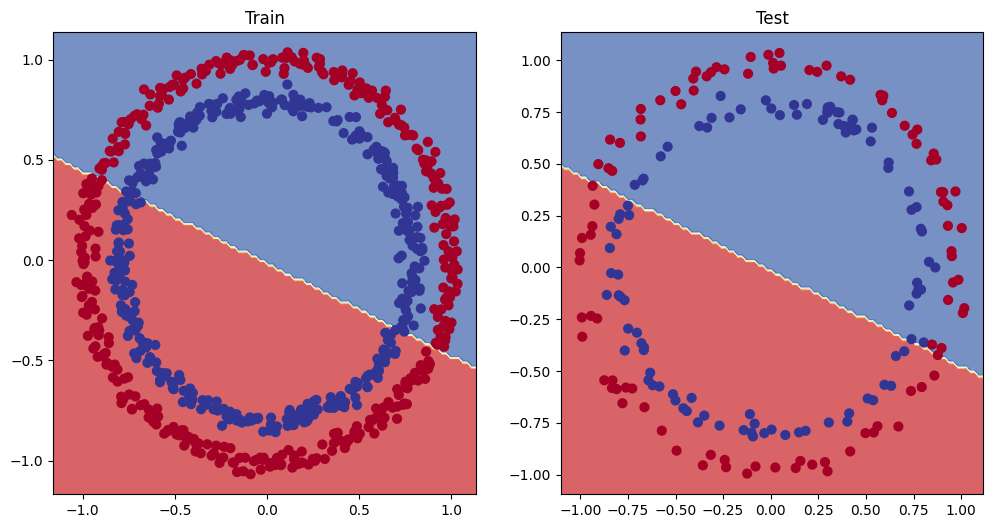

In [32]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [33]:
# improve a model

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# Create a loss func
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69396 | Acc: 50.87500% | Test loss: 0.69261 | Test acc: 51.00%
Epoch: 100 | Loss: 0.69305 | Acc: 50.37500% | Test loss: 0.69379 | Test acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Acc: 51.12500% | Test loss: 0.69437 | Test acc: 46.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.62500% | Test loss: 0.69458 | Test acc: 45.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.12500% | Test loss: 0.69465 | Test acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.00000% | Test loss: 0.69467 | Test acc: 46.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.00000% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.00000% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 800 | Loss: 0.69298 | Acc: 51.00000% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 900 | Loss: 0.69298 | Acc: 51.00000% | Test loss: 0.69468 | Test acc: 46.00%


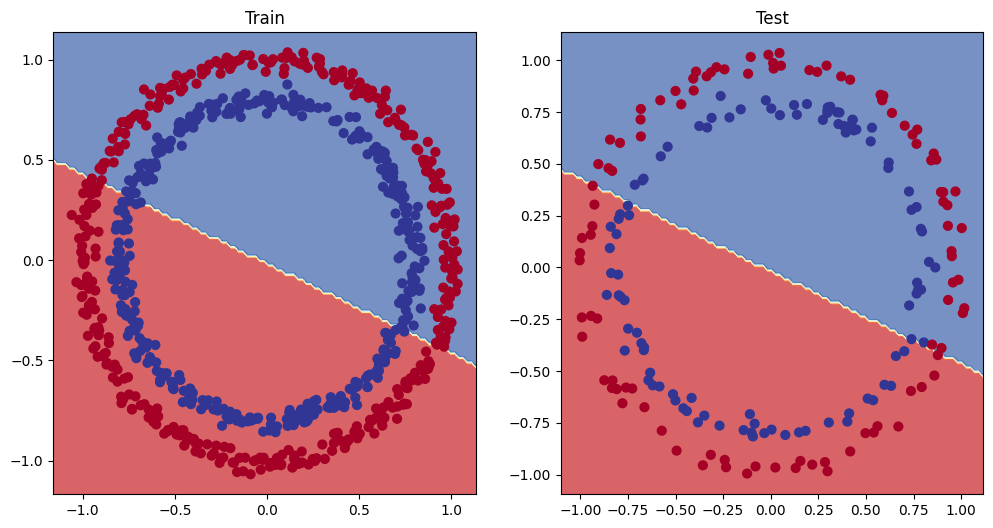

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [37]:
# Preparing data to see if our model can fit a straight line

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [38]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression)

(80, 20)

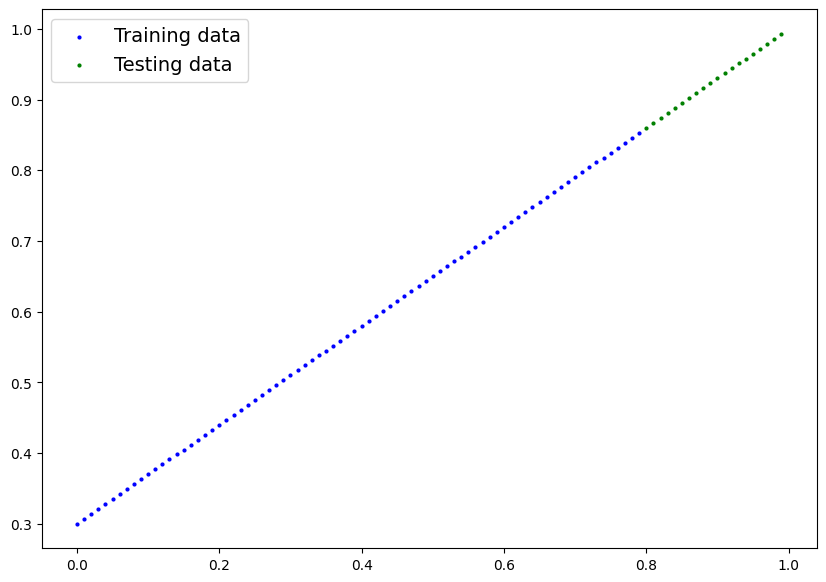

In [39]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

In [40]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)


In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_2.train()

    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}')
    

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


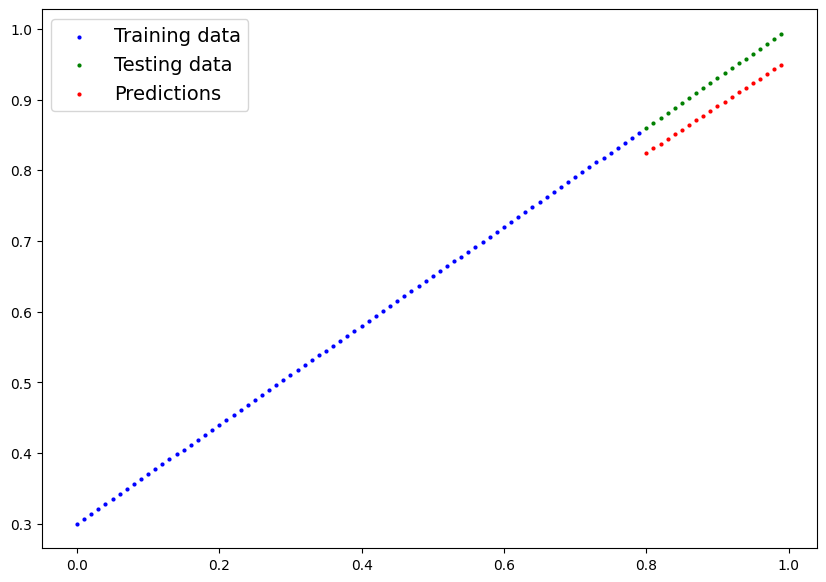

In [43]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression, predictions=y_preds)

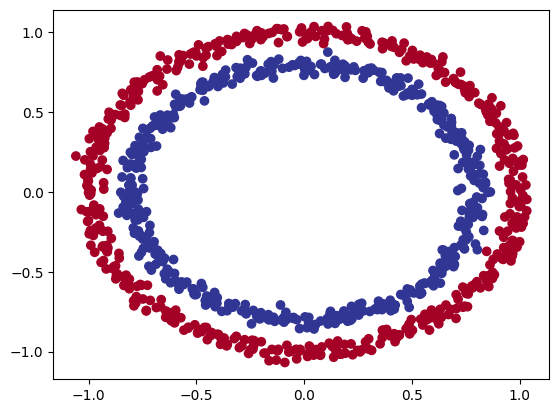

In [44]:
#Non-Linearity
plt.scatter(x=X[:, 0], y=X[:, 1], c = y, cmap=plt.cm.RdYlBu)

In [45]:
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [46]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2()
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [47]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)


In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3000

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69295 | Acc: 50.00000% | Test loss: 0.69319 | Test acc: 50.00%
Epoch: 100 | Loss: 0.69115 | Acc: 52.87500% | Test loss: 0.69102 | Test acc: 52.50%
Epoch: 200 | Loss: 0.68977 | Acc: 53.37500% | Test loss: 0.68940 | Test acc: 55.00%
Epoch: 300 | Loss: 0.68795 | Acc: 53.00000% | Test loss: 0.68723 | Test acc: 56.00%
Epoch: 400 | Loss: 0.68517 | Acc: 52.75000% | Test loss: 0.68411 | Test acc: 56.50%
Epoch: 500 | Loss: 0.68102 | Acc: 52.75000% | Test loss: 0.67941 | Test acc: 56.50%
Epoch: 600 | Loss: 0.67515 | Acc: 54.50000% | Test loss: 0.67285 | Test acc: 56.00%
Epoch: 700 | Loss: 0.66659 | Acc: 58.37500% | Test loss: 0.66322 | Test acc: 59.00%
Epoch: 800 | Loss: 0.65160 | Acc: 64.00000% | Test loss: 0.64757 | Test acc: 67.50%
Epoch: 900 | Loss: 0.62362 | Acc: 74.00000% | Test loss: 0.62145 | Test acc: 79.00%
Epoch: 1000 | Loss: 0.56818 | Acc: 87.75000% | Test loss: 0.57378 | Test acc: 86.50%
Epoch: 1100 | Loss: 0.48153 | Acc: 93.50000% | Test loss: 0.49935 | Test acc:

In [49]:
# Evaluating a model
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

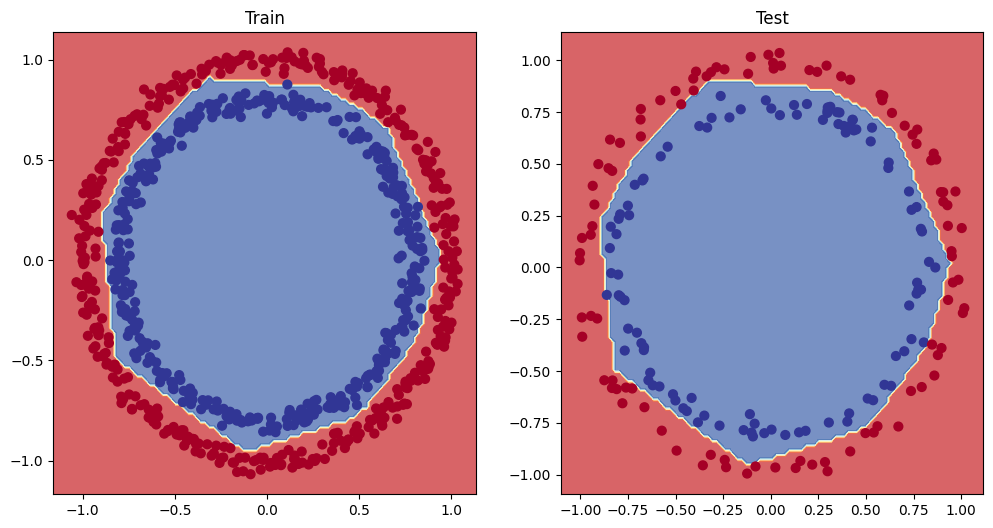

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [51]:
#Replicating non-linear activation func
A = torch.arange(-10, 10, 1, dtype=torch.float32)


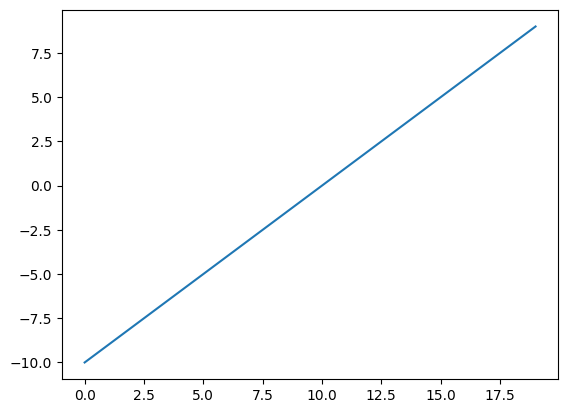

In [52]:
# Visualize the tensor
plt.plot(A)

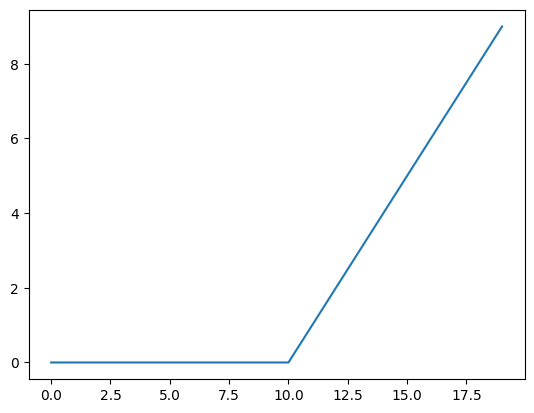

In [53]:
plt.plot(torch.relu(A))

In [54]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

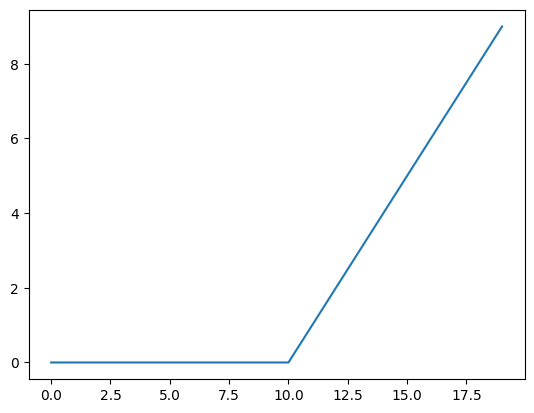

In [55]:
# Plot ReLu activation function
plt.plot(relu(A))

In [56]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

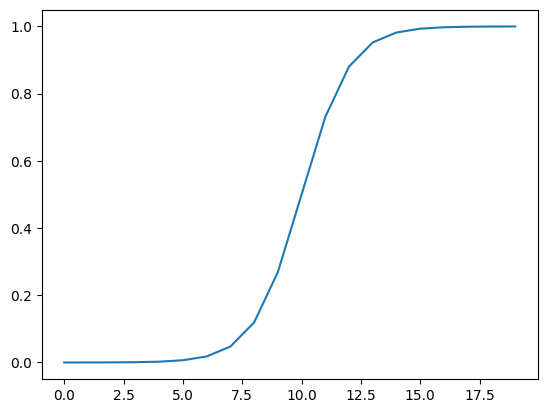

In [57]:
plt.plot(torch.sigmoid(A))

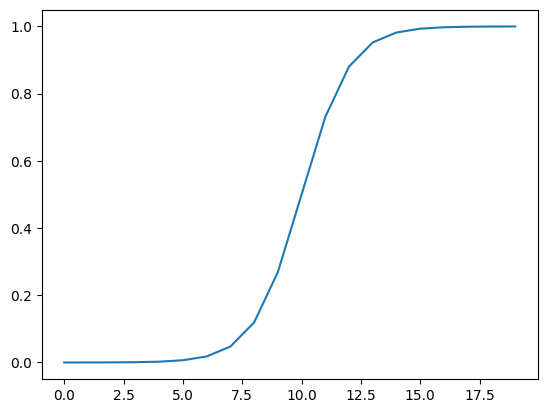

In [58]:
plt.plot(sigmoid(A))

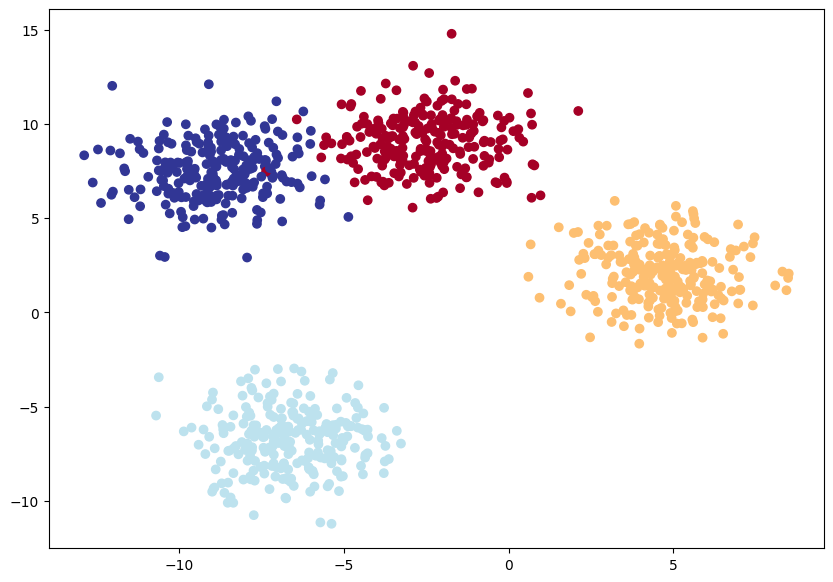

In [59]:
# Multi-class problem

from sklearn.datasets import make_blobs

# set the hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)
# turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#Split 
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, train_size=0.8, random_state=RANDOM_SEED)

# plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap=plt.cm.RdYlBu)

In [60]:
# Building a multi-class model

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [61]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [62]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [63]:
# Create a loss func and optim
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [64]:
#get preds 
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logits

tensor([[-7.6459e-01, -7.4120e-01, -1.5777e+00, -1.1376e+00],
        [-9.7256e-02, -9.4310e-01, -5.9631e-01, -1.3715e-01],
        [ 2.5277e-01, -2.3794e-01,  1.8817e-01, -6.5686e-03],
        [-4.1340e-01, -5.2042e-01, -9.3033e-01, -6.9626e-01],
        [-3.1184e-01, -1.3736e+00, -1.1991e+00, -3.8337e-01],
        [-1.4971e-01, -1.0617e+00, -7.1069e-01, -1.6452e-01],
        [ 1.5388e-01, -2.8874e-01,  1.5199e-01, -1.0874e-02],
        [-2.1543e-01, -1.1795e+00, -9.3000e-01, -2.7448e-01],
        [ 2.4432e-01, -2.4716e-01,  1.6492e-01,  6.1045e-03],
        [-2.3286e-01, -1.2120e+00, -9.8487e-01, -3.0037e-01],
        [-1.7742e-01, -1.1008e+00, -8.2929e-01, -2.3689e-01],
        [-9.4082e-01, -7.8985e-01, -1.8480e+00, -1.3347e+00],
        [-2.9723e-01, -1.3458e+00, -1.1543e+00, -3.6287e-01],
        [-2.9006e-01, -1.3393e+00, -1.1146e+00, -3.3518e-01],
        [-3.3713e-01, -1.4374e+00, -1.2379e+00, -3.8029e-01],
        [-1.0260e-01, -9.5066e-01, -6.1913e-01, -1.5105e-01],
        

In [65]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [66]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [67]:
torch.argmax(y_pred_probs[0])

tensor(1)

In [68]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [69]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [70]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true = y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%')

    

Epoch: 0 | Loss: 1.15883 | Acc: 40.37500% | Test loss: 1.07554 | Test acc: 48.00%
Epoch: 10 | Loss: 0.64476 | Acc: 96.75000% | Test loss: 0.66069 | Test acc: 97.50%
Epoch: 20 | Loss: 0.42535 | Acc: 98.50000% | Test loss: 0.43074 | Test acc: 100.00%
Epoch: 30 | Loss: 0.25294 | Acc: 99.12500% | Test loss: 0.24508 | Test acc: 99.50%
Epoch: 40 | Loss: 0.11232 | Acc: 99.25000% | Test loss: 0.10229 | Test acc: 99.50%
Epoch: 50 | Loss: 0.06627 | Acc: 99.25000% | Test loss: 0.05848 | Test acc: 99.50%
Epoch: 60 | Loss: 0.05068 | Acc: 99.25000% | Test loss: 0.04293 | Test acc: 99.50%
Epoch: 70 | Loss: 0.04300 | Acc: 99.25000% | Test loss: 0.03491 | Test acc: 99.50%
Epoch: 80 | Loss: 0.03836 | Acc: 99.25000% | Test loss: 0.02988 | Test acc: 99.50%
Epoch: 90 | Loss: 0.03525 | Acc: 99.25000% | Test loss: 0.02663 | Test acc: 99.50%


In [71]:
# making and evaluating preds
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [72]:
y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_pred[:10]

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0])

In [73]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

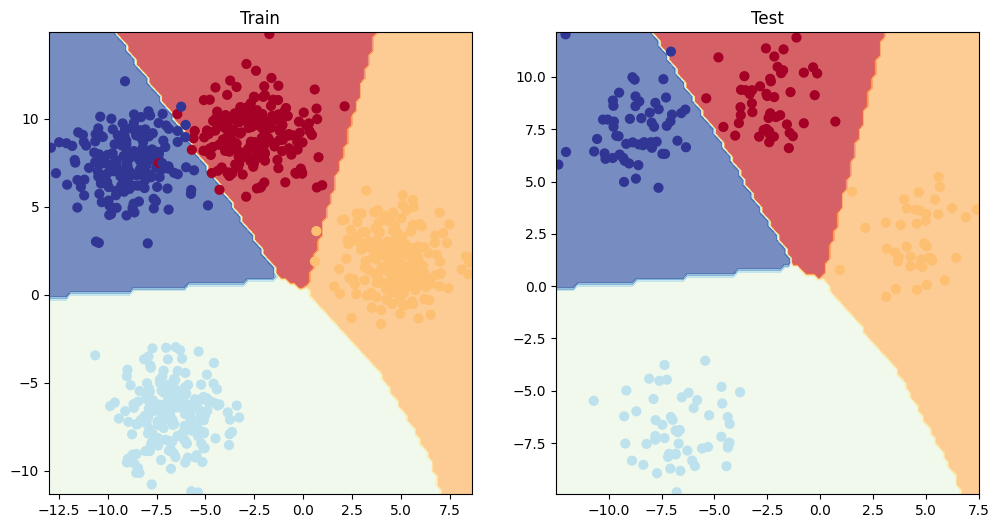

In [74]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [75]:
# a few more classification metrics
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES)

torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950)